# Prediction of annual income levels and ranking of feature importance

## DAT 402 Shan Jiang

## Introduction
#### Many factors can influence the earning capability of a person, including but not limited to age, gender, ethnicity, education year, occupation etc.. However, it’s unclear the differences of the contributions of these factors to the income levels, in other words, the ranking of the importance of these factors to the income levels is unknown. In this project, I asked the question: can I predict the income level with a person's characteristic information? what are the most important factor(s) which influence his/her annual income? I leveraged the “Adult Income” dataset from UC Irvine Machine Learning Depository (https://archive.ics.uci.edu/dataset/2/adult) to build prediction models, assess the relations between these potential factors and annual income level (>50k or <=50k), and prioritize their contributions accordingly.

### Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
#from keras.datasets import fashion_mnist
from tensorflow.keras import layers
from sklearn.inspection import permutation_importance
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

2025-05-01 17:02:29.645729: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 17:02:29.953139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Exploration

In [2]:
dat_df = pd.read_csv("adult.data", header=None, na_values='?', skipinitialspace=True)
#df.columns = ["Column A", "Column B"]
dat_df.columns = ['age','workClass','fnlwgt','edu','eduNum','maritalStatus','occupation','relationship','race','sex','capital_gain','capital_loss','hoursPerWeek','nativeCountry','class']

In [3]:
dat_df

age         workClass  fnlwgt         edu  eduNum       maritalStatus  \
0       39         State-gov   77516   Bachelors      13       Never-married   
1       50  Self-emp-not-inc   83311   Bachelors      13  Married-civ-spouse   
2       38           Private  215646     HS-grad       9            Divorced   
3       53           Private  234721        11th       7  Married-civ-spouse   
4       28           Private  338409   Bachelors      13  Married-civ-spouse   
...    ...               ...     ...         ...     ...                 ...   
32556   27           Private  257302  Assoc-acdm      12  Married-civ-spouse   
32557   40           Private  154374     HS-grad       9  Married-civ-spouse   
32558   58           Private  151910     HS-grad       9             Widowed   
32559   22           Private  201490     HS-grad       9       Never-married   
32560   52      Self-emp-inc  287927     HS-grad       9  Married-civ-spouse   

              occupation   relationship   race     sex  capital_gain  \
0           Adm-clerical  Not-in-family  White    Male          2174   
1        Exec-managerial        Husband  White    Male             0   
2      Handlers-cleaners  Not-in-family  White    Male             0   
3      Handlers-cleaners        Husband  Black    Male             0   
4         Prof-specialty           Wife  Black  Female             0   
...                  ...            ...    ...     ...           ...   
32556       Tech-support           Wife  White  Female             0   
32557  Machine-op-inspct        Husband  White    Male             0   
32558       Adm-clerical      Unmarried  White  Female             0   
32559       Adm-clerical      Own-child  White    Male             0   
32560    Exec-managerial           Wife  White  Female         15024   

       capital_loss  hoursPerWeek  nativeCountry  class  
0                 0            40  United-States  <=50K  
1                 0            13  United-States  <=50K  
2                 0            40  United-States  <=50K  
3                 0            40  United-States  <=50K  
4                 0            40           Cuba  <=50K  
...             ...           ...            ...    ...  
32556             0            38  United-States  <=50K  
32557             0            40  United-States   >50K  
32558             0            40  United-States  <=50K  
32559             0            20  United-States  <=50K  
32560             0            40  United-States   >50K  

[32561 rows x 15 columns]

In [4]:
numFtName = ['age','fnlwgt','eduNum','capital_gain','capital_loss','hoursPerWeek']
catFtName = ['workClass','edu','maritalStatus','occupation','relationship','race','sex','nativeCountry']
numFtDf = dat_df[numFtName]
catFtDf = dat_df[catFtName]

#### Histograms for numerical features

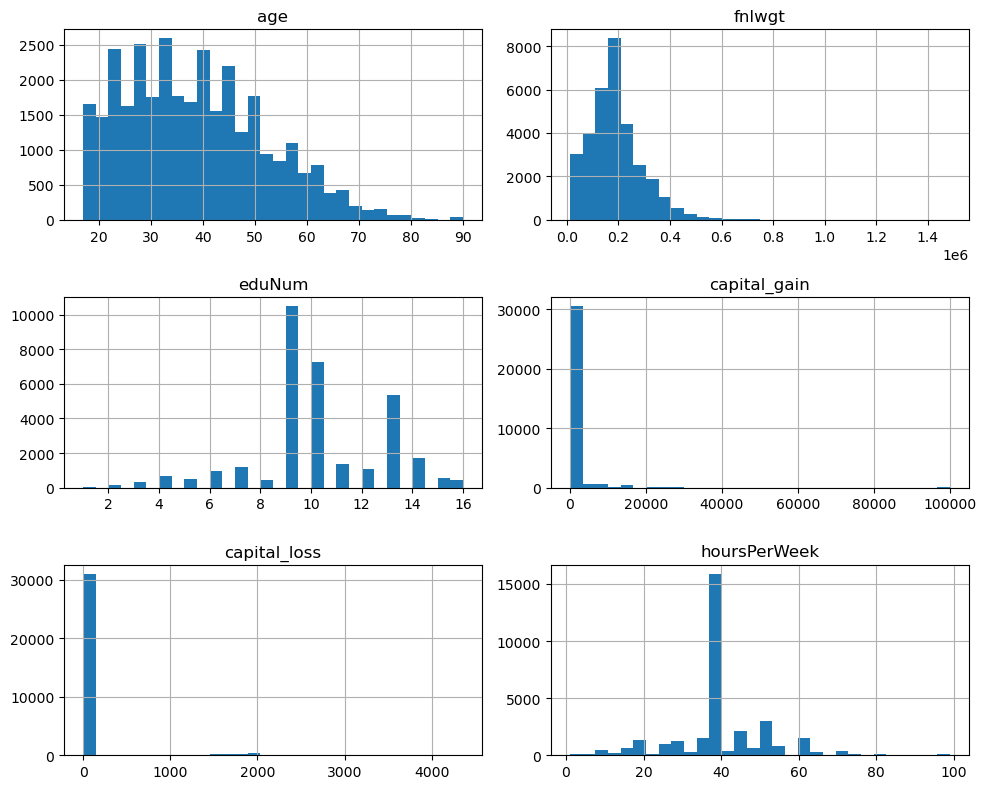

In [6]:
numFtDf.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

#### Bar plots for categorical features

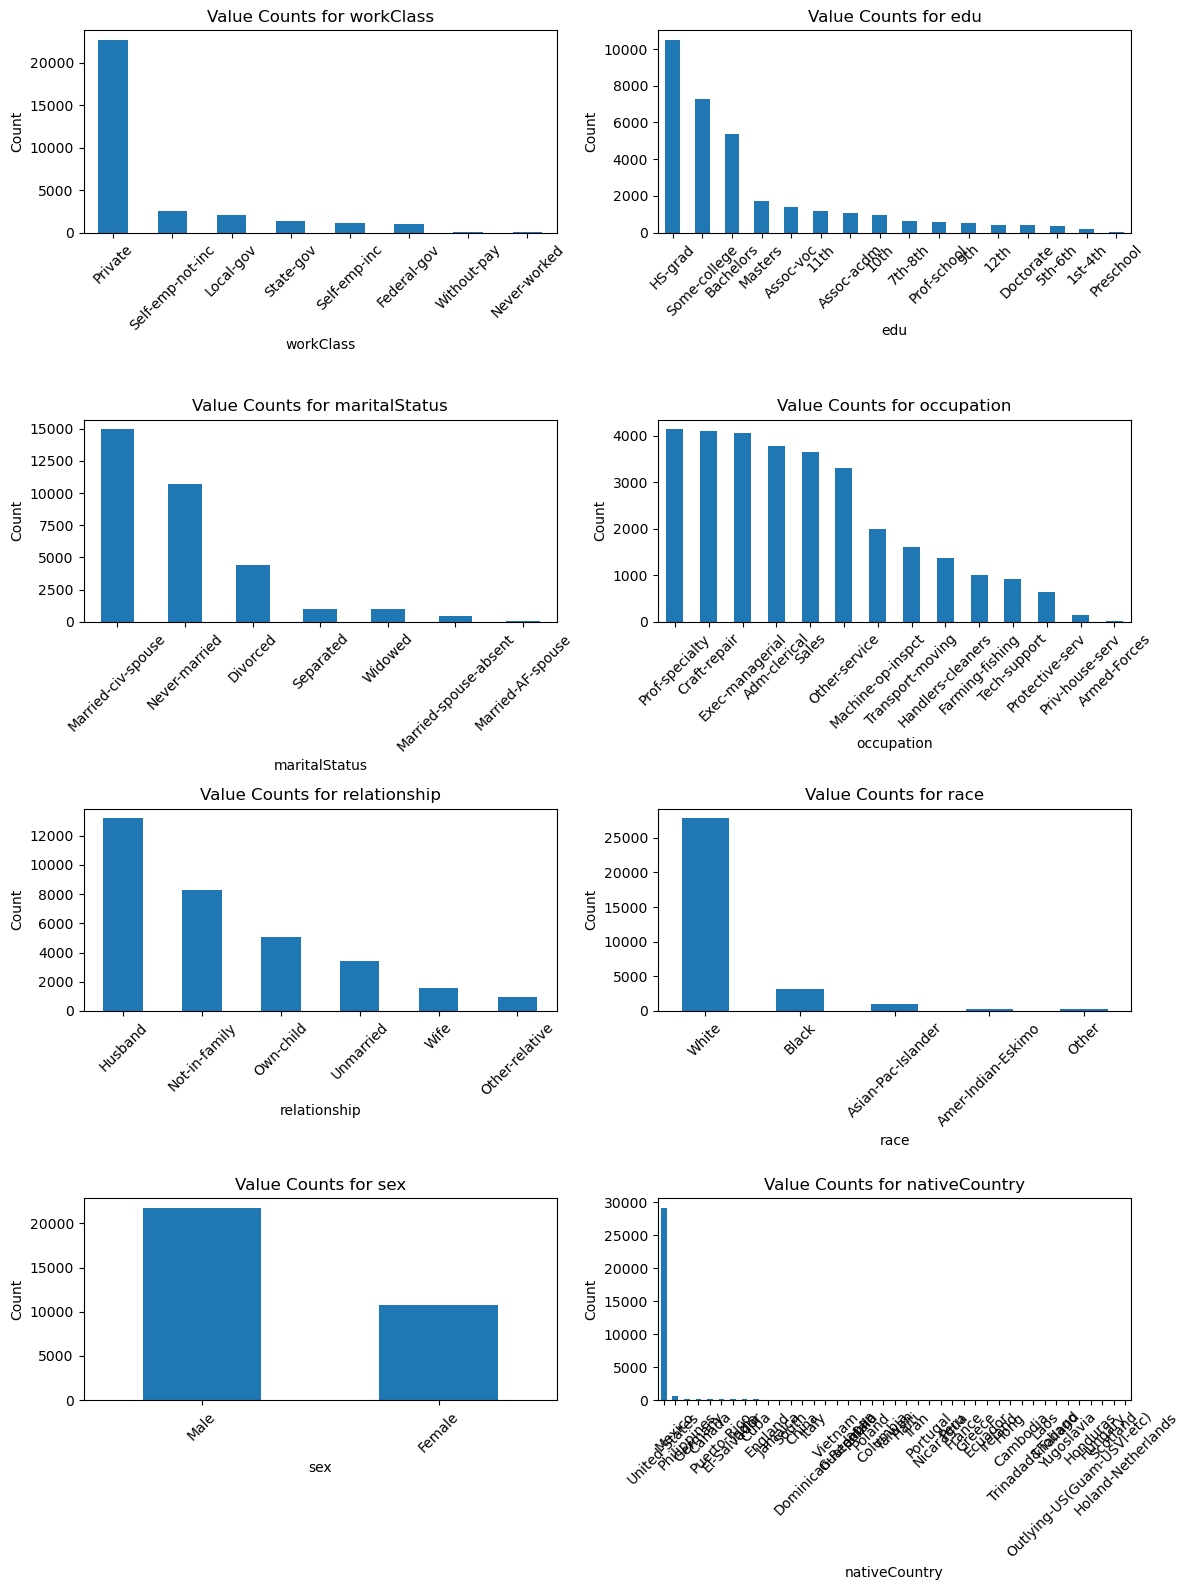

In [9]:
# Assuming df is your DataFrame with all categorical columns
categorical_cols = catFtDf.columns[:8]  # Select first 8 columns (or change as needed)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    catFtDf[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Value Counts for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots if fewer than 8 columns
for j in range(len(categorical_cols), 8):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Data Cleaning and Wrangling

In [3]:
#remove rows contain na value
dat_df2 = dat_df.dropna()

#### How many samples containing NA values were removed?

In [4]:
len(dat_df)-len(dat_df2)

2399

#### Because the data contain a lot of dash signs "-" which can be confused with mathematical minus sign, I replaced all "-" with "_".

In [5]:
dat_df2 = dat_df2.replace('-', '_', regex=True)

#### Because columns "edu" and "eduNum" reveal the same information, I included only the feature "eduNum" to build models.

In [6]:
dat_df2 = dat_df2.drop('edu',axis=1)

#### Next, I recode the target variable "class" as numerical values 

In [7]:
dat_df2['class'] = dat_df2['class'].map({'<=50K': 0, '>50K': 1})

#### For categorical features, I plan to use OneHotEncoder to generate a dummy feature for each individual value for a given categorical feature. But the feature "nativeCountry" has too many values with very few cases. For this feature, I coded all the countries other than "United_States" as "abroad". Then, "United_States" is mapped to 0 and "abroad" is mapped to 1.

In [8]:
dat_df2['nativeCountry'] = np.where(dat_df2['nativeCountry'] == 'United_States', 0, 1)

#### The feature "sex" has only two values "Male" and "Female". I recoded it directly without OneHotEncoder.

In [10]:
dat_df2['sex'] = np.where(dat_df2['sex'] == 'Female', 0, 1)

#### For all the other categorical features, I applied OneHotEncoder on them.

In [12]:
# Identify categorical columns
df = dat_df2
ohe = OneHotEncoder()

categorical_cols = ['workClass', 'maritalStatus', 'occupation', 'relationship', 'race']

# One-hot encode the categorical columns with dense output and get feature names
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
array_hot_encoded = ohe.fit_transform(df[categorical_cols])

# Create a DataFrame with the new column names
encoded_col_names = ohe.get_feature_names_out(categorical_cols)
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns=encoded_col_names, index=df.index)

# Drop original categorical columns
data_other_cols = df.drop(columns=categorical_cols)

# Concatenate the two dataframes
df2 = pd.concat([data_hot_encoded, data_other_cols], axis=1)

/home/shann/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Then, I scaled all the numerical features.

In [15]:
numerical_cols = ['age','fnlwgt','eduNum','capital_gain','capital_loss','hoursPerWeek']
# Step 2: Create the scaler and apply it
scaler = StandardScaler()
df_scaled = df2.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df2[numerical_cols])

In [19]:
X = df_scaled.drop('class', axis=1)
y = df_scaled['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### I used PCA to examine if the income levels can be separated with the top 2 PCs.

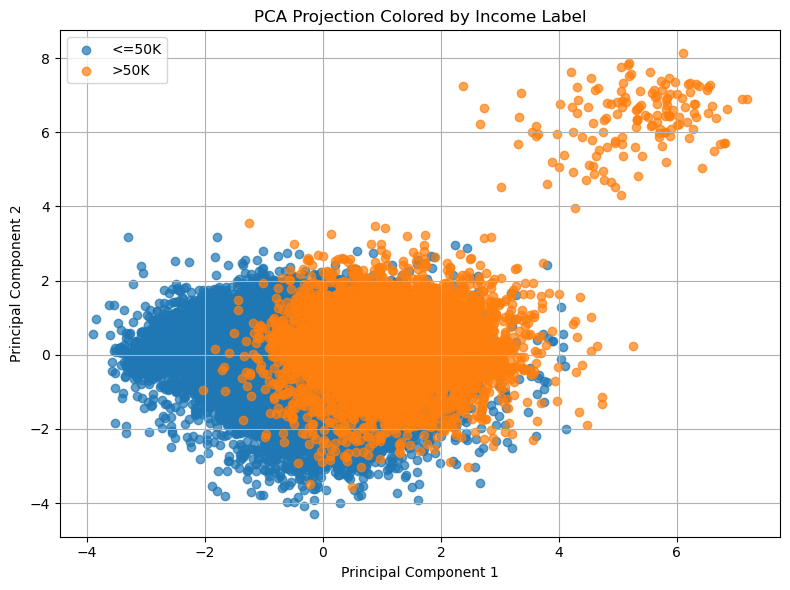

In [140]:
# Step 2: Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Step 3: Create a DataFrame with PCA results and labels
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    #'PC3': X_pca[:, 2],
    'Label': y
})

pca_df['Label'] = pca_df['Label'].map({0: '<=50K', 1: '>50K'})

plt.figure(figsize=(8, 6))

for label in pca_df['Label'].unique():
    subset = pca_df[pca_df['Label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection Colored by Income Label')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Then I checked the top 3 PCs. The samples are separated better than using only the top 2 PCs. What more interesting is that the samples were clustered in three obvious and distinct clusters in 3D PCA, and one of the clusters consisted of only individuals with more than 50K.

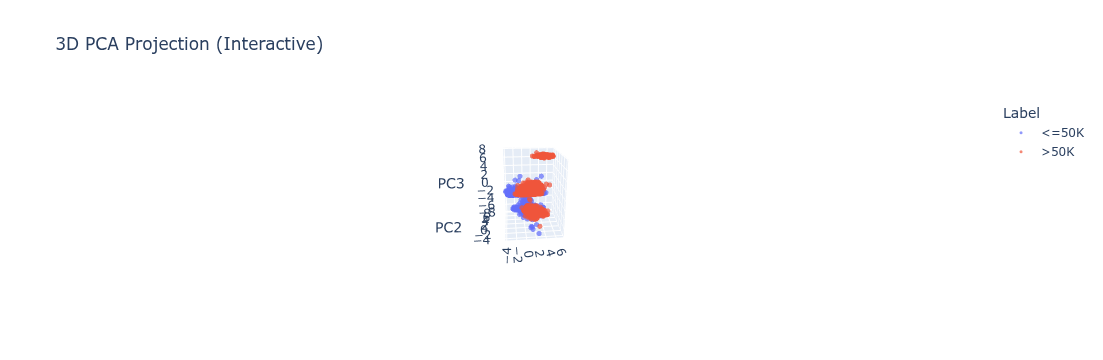

In [143]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create DataFrame with 3 PCs
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'Label': y
})

# Optional: Map label for readability
pca_df['Label'] = pca_df['Label'].map({0: '<=50K', 1: '>50K'})

# Interactive 3D scatter plot
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Label',
    opacity=0.7,
    title='3D PCA Projection (Interactive)'
)

fig.update_traces(marker=dict(size=3))

fig.show()

### Neural Network

In [130]:
np.random.seed(123) #set the seed in numpy (do NOT remove this)
tf.random.set_seed(1234)  #set the seed in tensorflow (do NOT remove this)

# your code here
#raise NotImplementedError
#building the architecture of the model
mynet = tf.keras.Sequential([
    #layers.Dense(units=47, name='input_layer'), #reshaping image to vector (flattening)
    layers.Dense(units=64, activation='tanh',input_shape=(47,), name='hidden1'),
    #layers.Dense(units=128, activation='relu', name='hidden2'),
    #layers.Dense(units=128, activation='relu', name='hidden3'),
    layers.Dense(units=1, activation='sigmoid', name='output_layer')
], name='mynet') #name is used in printout (can be different from 'mynet')

mynet.compile(optimizer='adam',     #rmsprop
              loss='binary_crossentropy',
              metrics=['accuracy'])

mynet.summary()

Model: "mynet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 64)                3072      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


#### I manually fine-tuned several hyperparameters, including **number of hidden layers**, **number of nodes of a hidden layer**, **activation function of hidden layer** and **optimizers**. I observed decreased accuracy with increased number of hidden layers due to overfitting (accuracy increases in training set but decrease in test set with increased number of hidden layers). Number of nodes of a hidden layer was optimized at 64. Optimizers (rmsprop or adam) do not significantly influence the model performance. The performance with tanh activation is better than relu.

In [131]:
mynet.fit(x=X_train, y=y_train, epochs=100, batch_size=512)

Epoch 1/100
45/45 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.6809
Epoch 2/100
45/45 [==============================] - 0s 865us/step - loss: 0.3812 - accuracy: 0.8275
Epoch 3/100
45/45 [==============================] - 0s 915us/step - loss: 0.3512 - accuracy: 0.8369
Epoch 4/100
45/45 [==============================] - 0s 880us/step - loss: 0.3412 - accuracy: 0.8413
Epoch 5/100
45/45 [==============================] - 0s 930us/step - loss: 0.3358 - accuracy: 0.8428
Epoch 6/100
45/45 [==============================] - 0s 905us/step - loss: 0.3322 - accuracy: 0.8445
Epoch 7/100
45/45 [==============================] - 0s 842us/step - loss: 0.3303 - accuracy: 0.8447
Epoch 8/100
45/45 [==============================] - 0s 1ms/step - loss: 0.3285 - accuracy: 0.8460
Epoch 9/100
45/45 [==============================] - 0s 877us/step - loss: 0.3273 - accuracy: 0.8463
Epoch 10/100
45/45 [==============================] - 0s 945us/step - loss: 0.3263 - accuracy: 

In [132]:
test_loss, test_acc = mynet.evaluate(X_test, y_test, verbose=2)

236/236 - 0s - loss: 0.3085 - accuracy: 0.8582 - 151ms/epoch - 642us/step


#### Then I extracted the weights (or coefficients) from the hidden layer as the feature importance.

In [133]:
# Get weights of the first Dense layer
weights, biases = mynet.get_layer('hidden1').get_weights()

# weights.shape = (47, 64): 47 input features, 64 neurons
# Take mean absolute weight per feature
importance = np.mean(np.abs(weights), axis=1)

# If you have feature names, add them here
# feature_names = X.columns.tolist()  # If you're using a pandas DataFrame
feature_names = X.columns.tolist()

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                feature  importance
22           occupation_Priv_house_serv    0.445278
6                 workClass_Without_pay    0.428401
43                         capital_gain    0.271382
4            workClass_Self_emp_not_inc    0.260958
24           occupation_Protective_serv    0.238826
39                                  age    0.226462
45                         hoursPerWeek    0.213913
15              occupation_Armed_Forces    0.213642
33                    relationship_Wife    0.212086
26              occupation_Tech_support    0.196315
18           occupation_Farming_fishing    0.194624
8       maritalStatus_Married_AF_spouse    0.193239
1                   workClass_Local_gov    0.193147
35              race_Asian_Pac_Islander    0.193068
0                 workClass_Federal_gov    0.188607
37                           race_Other    0.187734
30          relationship_Other_relative    0.184596
41                               eduNum    0.182486
13          

### Random Forest

In [147]:
forest = RandomForestClassifier(n_estimators= 5, random_state= 42)
forest.fit(X_train, y_train)
#evaluate random forest model on test set
forest_pred = forest.predict(X_test)
# model accuracy on test set
print("Accuracy on test set: {:.3f}".format(accuracy_score(forest_pred,y_test)))

Accuracy on test set: 0.839


#### Because it's relatively easier to fine-tune the hyperparameters for random forest and less time-consuming, I fine-tuned random forest in terms of splitting criterion, max_leaf_nodes and max_depth with cross validation with grid search.

In [156]:
####this step is time-consuming!!!!
#params = {'n_estimators':list(range(2,10)),'criterion':['gini','entropy'],'max_leaf_nodes':list(range(6,15)),'max_depth':np.arange(3,15)}
params = {'criterion':['gini','entropy'],'max_leaf_nodes':list(range(6,15)),'max_depth':np.arange(3,15)}
forest_grid = GridSearchCV(RandomForestClassifier(n_estimators=100,random_state=42), params, cv=10)
forest_grid.fit(X, y)
# best parameters returned by GridSearchCV()
forest_grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=14,
                       random_state=42)

In [159]:
# evaluate model performance of best model on test set
best_forest = forest_grid.best_estimator_
y_pred_grid = best_forest.predict(X_test)
accuracy_score(y_test,y_pred_grid)

0.8437872961145737

In [160]:
importance = best_forest.feature_importances_
# create a dataframe for feature importance
feature_importance = pd.DataFrame(importance, index= feature_names, columns=["Importance"])
# sort feature importance
feature_importance.sort_values(by=["Importance"], ascending= False)

Importance
maritalStatus_Married_civ_spouse       0.208523
relationship_Husband                   0.144305
capital_gain                           0.129764
eduNum                                 0.120208
maritalStatus_Never_married            0.077920
age                                    0.067683
relationship_Own_child                 0.037630
hoursPerWeek                           0.033323
sex                                    0.026749
occupation_Exec_managerial             0.023785
occupation_Prof_specialty              0.021663
capital_loss                           0.020681
relationship_Wife                      0.018646
relationship_Not_in_family             0.018063
relationship_Unmarried                 0.012041
maritalStatus_Divorced                 0.008768
occupation_Other_service               0.008465
workClass_Self_emp_inc                 0.003564
workClass_Private                      0.002732
occupation_Farming_fishing             0.002431
occupation_Handlers_cleaners           0.002375
occupation_Craft_repair                0.002190
occupation_Machine_op_inspct           0.001706
maritalStatus_Separated                0.001286
workClass_Self_emp_not_inc             0.000834
occupation_Transport_moving            0.000789
race_Black                             0.000667
occupation_Adm_clerical                0.000652
nativeCountry                          0.000469
race_White                             0.000420
occupation_Tech_support                0.000409
workClass_Federal_gov                  0.000381
relationship_Other_relative            0.000379
occupation_Sales                       0.000196
maritalStatus_Married_spouse_absent    0.000090
fnlwgt                                 0.000061
race_Other                             0.000058
race_Amer_Indian_Eskimo                0.000037
maritalStatus_Widowed                  0.000030
workClass_Local_gov                    0.000028
occupation_Protective_serv             0.000000
race_Asian_Pac_Islander                0.000000
occupation_Priv_house_serv             0.000000
occupation_Armed_Forces                0.000000
maritalStatus_Married_AF_spouse        0.000000
workClass_Without_pay                  0.000000
workClass_State_gov                    0.000000

### Performance comparison between neural network and random forest

236/236 [==============================] - 0s 403us/step


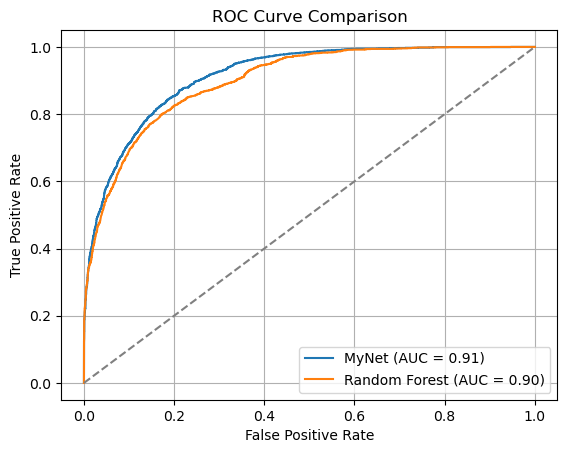

In [172]:
# For mynet (Neural Network)
y_pred_probs_mynet = mynet.predict(X_test).ravel()

# For best_forest (Random Forest)
y_pred_probs_forest = best_forest.predict_proba(X_test)[:, 1]

# ROC for mynet
fpr_mynet, tpr_mynet, _ = roc_curve(y_test, y_pred_probs_mynet)
roc_auc_mynet = auc(fpr_mynet, tpr_mynet)

# ROC for best_forest
fpr_forest, tpr_forest, _ = roc_curve(y_test, y_pred_probs_forest)
roc_auc_forest = auc(fpr_forest, tpr_forest)

plt.figure()

# Plot mynet
plt.plot(fpr_mynet, tpr_mynet, label=f'MyNet (AUC = {roc_auc_mynet:.2f})')

# Plot best_forest
plt.plot(fpr_forest, tpr_forest, label=f'Random Forest (AUC = {roc_auc_forest:.2f})')

# Random line (no skill line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Conclusion
#### I built a neural network and a random forest to predict income level with demographic characteristics, such as age, sex, and education year, as features. The performance of the neural network is slightly better than that of the random forest in terms of ROC curves and AUC values. Both algorithms prioritize the feature **capital_gain** to render its contribution to the income level. Interestingly and also the limitation for the analysis, the samples were clustered in three obvious and distinct clusters in 3D PCA, and one of the clusters consisted of only individuals with more than 50K, which suggests stratification of the samples and model-building within a cluster may improve the model performance. I expect to explore the dataset a step further based on the different clusters, which may help to reveal some hidden insights.